# Practice: Handling Missing Data
Aug 19, 2019<br>
Ngoc Tran<br>
(Inspired by: https://www.kaggle.com/dansbecker/handling-missing-values)

------------------------------------

## Import

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import warnings

from fancyimpute import KNN
from pathlib import Path
from sklearn.impute import SimpleImputer

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Change directory to get change directory source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

## Load data

Change directory to get data:

In [5]:
cd = change_directory.ChangeDirectory()

In [6]:
cd.change_to_data_dir()

Load data:

In [7]:
ih_1 = pd.read_csv("Iowa_Housing_1.csv")
ih_2 = pd.read_csv("Iowa_Housing_2.csv")
ih = pd.concat([ih_1, ih_2]).reset_index(drop=True)

Change back to notebook directory:

In [8]:
cd.change_to_notebook_dir()

## Explore data

Quick look:

In [9]:
ih.shape

(2919, 81)

In [10]:
ih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2454 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

For the sake of simplicity, we use only numeric predictors.

In [11]:
ih = ih.select_dtypes(exclude=["object"])

In [12]:
ih.shape

(2919, 38)

In [13]:
ih.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0


Duplicates?

In [14]:
len(ih[ih.duplicated()])

0

How many rows have missing values per column?

In [15]:
ih.isna().sum().sort_values(ascending=False)

LotFrontage      465
GarageYrBlt      159
MasVnrArea        23
BsmtHalfBath       2
BsmtFullBath       2
GarageCars         1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageArea         1
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
LotArea            0
GrLivArea          0
MSSubClass         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
SalePrice          0
YrSold             0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
Id                 0
dtype: int64

We don't need the Id column.

In [16]:
ih.drop(["Id"], axis=1, inplace=True)

Let's set 500 rows (with no missing values) aside for our test set.

In [17]:
rows_no_missing_values = ih[~ih.isna().any(axis=1)].reset_index(drop=True)

In [18]:
rows_no_missing_values_randomized = rows_no_missing_values.sample(len(rows_no_missing_values),
                                                                  random_state=123)

In [19]:
test = rows_no_missing_values_randomized[:500].reset_index(drop=True)

Our training set includes all of the other rows.

In [20]:
rows_missing_values = ih[ih.isna().any(axis=1)].reset_index(drop=True)

In [21]:
training = pd.concat([rows_missing_values, rows_no_missing_values_randomized[500:]]).reset_index(drop=True)

Which columns have missing values?

In [22]:
cols_with_missing = list(training.columns[training.isna().any()])
print(len(cols_with_missing))
print(cols_with_missing)

11
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


### LotFrontage

In [23]:
training.LotFrontage.isna().sum()

465

In [24]:
training.LotFrontage.describe()

count    1954.000000
mean       69.160184
std        23.986565
min         0.000000
25%        58.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

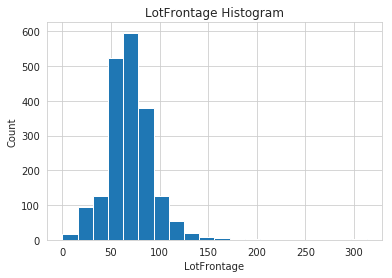

In [25]:
training.LotFrontage.hist(bins=20);
plt.title("LotFrontage Histogram");
plt.xlabel("LotFrontage");
plt.ylabel("Count");

Median $\approx$ mean.

### MasVnrArea

In [26]:
training.MasVnrArea.isna().sum()

23

In [27]:
training.MasVnrArea.describe()

count    2396.000000
mean      103.737896
std       181.967988
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

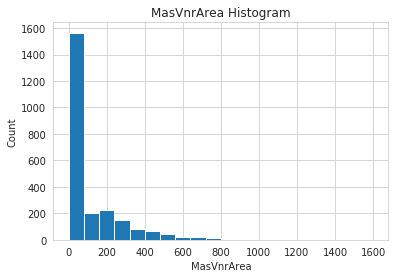

In [28]:
training.MasVnrArea.hist(bins=20);
plt.title("MasVnrArea Histogram");
plt.xlabel("MasVnrArea");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtFinSF1

In [29]:
training.BsmtFinSF1.isna().sum()

1

In [30]:
training.BsmtFinSF1.describe()

count    2418.000000
mean      448.796940
std       449.840161
min         0.000000
25%         0.000000
50%       375.000000
75%       746.750000
max      4010.000000
Name: BsmtFinSF1, dtype: float64

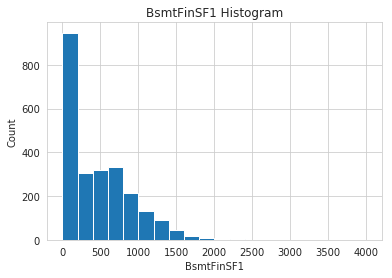

In [31]:
training.BsmtFinSF1.hist(bins=20);
plt.title("BsmtFinSF1 Histogram");
plt.xlabel("BsmtFinSF1");
plt.ylabel("Count");

There's only 1 missing value. Using median is fine.

### BsmtFinSF2

In [32]:
training.BsmtFinSF2.isna().sum()

1

In [33]:
training.BsmtFinSF2.describe()

count    2418.000000
mean       49.265095
std       168.871206
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64

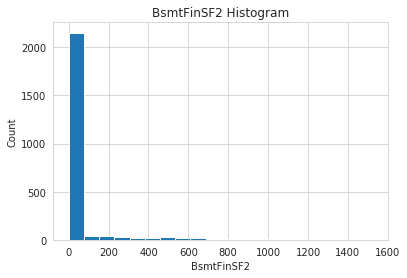

In [34]:
training.BsmtFinSF2.hist(bins=20);
plt.title("BsmtFinSF2 Histogram");
plt.xlabel("BsmtFinSF2");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtUnfSF

In [35]:
training.BsmtUnfSF.isna().sum()

1

In [36]:
training.BsmtUnfSF.describe()

count    2418.000000
mean      552.097601
std       437.915333
min         0.000000
25%       215.000000
50%       460.000000
75%       796.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

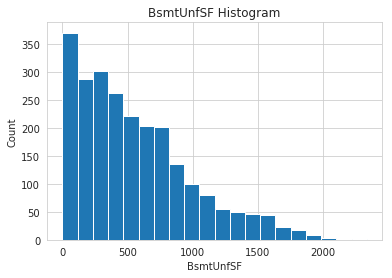

In [37]:
training.BsmtUnfSF.hist(bins=20);
plt.title("BsmtUnfSF Histogram");
plt.xlabel("BsmtUnfSF");
plt.ylabel("Count");

There's only 1 missing value. Using median is fine.

### TotalBsmtSF

In [38]:
training.TotalBsmtSF.isna().sum()

1

In [39]:
training.TotalBsmtSF.describe()

count    2418.000000
mean     1050.159636
std       432.563818
min         0.000000
25%       793.000000
50%       990.500000
75%      1297.750000
max      5095.000000
Name: TotalBsmtSF, dtype: float64

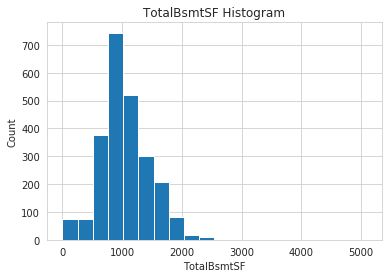

In [40]:
training.TotalBsmtSF.hist(bins=20);
plt.title("TotalBsmtSF Histogram");
plt.xlabel("TotalBsmtSF");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtFullBath

In [41]:
training.BsmtFullBath.isna().sum()

2

In [42]:
training.BsmtFullBath.describe()

count    2417.000000
mean        0.434837
std         0.528957
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

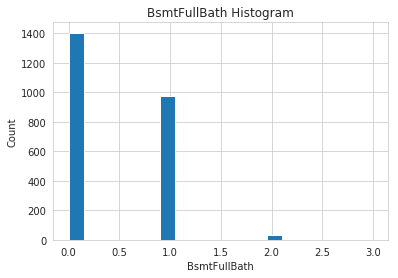

In [43]:
training.BsmtFullBath.hist(bins=20);
plt.title("BsmtFullBath Histogram");
plt.xlabel("BsmtFullBath");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### BsmtHalfBath

In [44]:
training.BsmtHalfBath.isna().sum()

2

In [45]:
training.BsmtHalfBath.describe()

count    2417.000000
mean        0.061647
std         0.245670
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

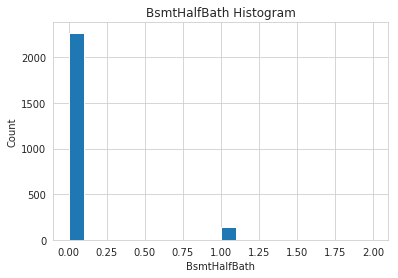

In [46]:
training.BsmtHalfBath.hist(bins=20);
plt.title("BsmtHalfBath Histogram");
plt.xlabel("BsmtHalfBath");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### GarageYrBlt

In [47]:
training.GarageYrBlt.isna().sum()

159

In [48]:
training.GarageYrBlt.describe()

count    2260.000000
mean     1978.062832
std        25.255797
min      1895.000000
25%      1961.000000
50%      1979.000000
75%      2001.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

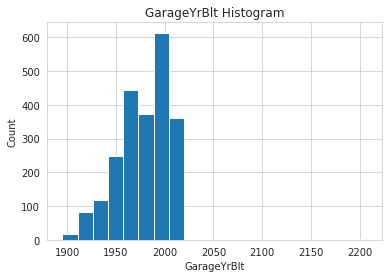

In [49]:
training.GarageYrBlt.hist(bins=20);
plt.title("GarageYrBlt Histogram");
plt.xlabel("GarageYrBlt");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### GarageCars

In [50]:
training.GarageCars.isna().sum()

1

In [51]:
training.GarageCars.describe()

count    2418.000000
mean        1.755997
std         0.783053
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: GarageCars, dtype: float64

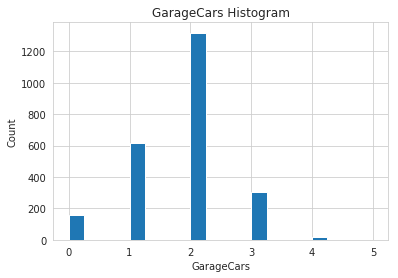

In [52]:
training.GarageCars.hist(bins=20);
plt.title("GarageCars Histogram");
plt.xlabel("GarageCars");
plt.ylabel("Count");

Median seems to be a better central tendency measurement for this feature.

### GarageArea

In [53]:
training.GarageArea.isna().sum()

1

In [54]:
training.GarageArea.describe()

count    2418.000000
mean      470.114557
std       220.176998
min         0.000000
25%       318.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: GarageArea, dtype: float64

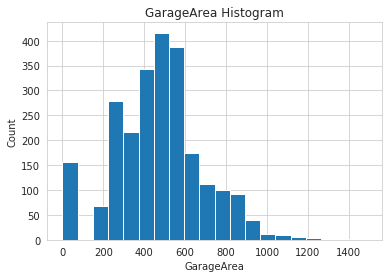

In [55]:
training.GarageArea.hist(bins=20);
plt.title("GarageArea Histogram");
plt.xlabel("GarageArea");
plt.ylabel("Count");

There's only 1 missing value. Using median is fine.

## Techniques to treat missing values:

Change directory to get model performance source code:

In [56]:
cd.change_to_src_models_dir()

More import:

In [57]:
from model_performance import mean_abs_error

Change back to notebook directory:

In [58]:
cd.change_to_notebook_dir()

### Drop Rows with Missing Values

In [59]:
training_drop_rows = training.copy()
test_drop_rows = test.copy()

In [60]:
training_drop_rows = training_drop_rows[~training_drop_rows.isna().any(axis=1)].reset_index(drop=True)

In [61]:
training_drop_rows_X = training_drop_rows.drop(["SalePrice"], axis=1)
training_drop_rows_y = training_drop_rows.SalePrice
test_drop_rows_X = test_drop_rows.drop(["SalePrice"], axis=1)
test_drop_rows_y = test_drop_rows.SalePrice

In [62]:
print("--- Dropping rows with missing values ---")
mae_drop_rows = mean_abs_error(training_drop_rows_X, test_drop_rows_X, training_drop_rows_y, test_drop_rows_y)

--- Dropping rows with missing values ---
Mean absolute error (training): 11245.923012602067
Mean absolute error (test):     28623.141663782004


### Drop Columns with Missing Values

In [63]:
training_drop_cols = training.copy()
test_drop_cols = test.copy()

In [64]:
training_drop_cols_X = training_drop_cols.drop(["SalePrice"], axis=1)
training_drop_cols_X = training_drop_cols.drop(cols_with_missing, axis=1)
training_drop_cols_y = training_drop_cols.SalePrice
test_drop_cols_X = test_drop_cols.drop(["SalePrice"], axis=1)
test_drop_cols_X = test_drop_cols.drop(cols_with_missing, axis=1)
test_drop_cols_y = test_drop_cols.SalePrice

In [65]:
print("--- Dropping columns with missing values ---")
mae_drop_cols = mean_abs_error(training_drop_cols_X, test_drop_cols_X, training_drop_cols_y, test_drop_cols_y)

--- Dropping columns with missing values ---
Mean absolute error (training): 98.39552372344068
Mean absolute error (test):     222.45193020099865


### Imputation (Statistical with Median)

In [66]:
training_imp_avg = training.copy()
test_imp_avg = test.copy()

In [67]:
imp_median = SimpleImputer(strategy="median")
training_imp_avg = pd.DataFrame(imp_median.fit_transform(training_imp_avg), columns=training_imp_avg.columns)

In [68]:
training_imp_avg_X = training_imp_avg.drop(["SalePrice"], axis=1)
training_imp_avg_y = training_imp_avg.SalePrice
test_imp_avg_X = test_imp_avg.drop(["SalePrice"], axis=1)
test_imp_avg_y = test_imp_avg.SalePrice

In [69]:
print("--- Imputation (statistical with median) ---")
mae_imp_avg = mean_abs_error(training_imp_avg_X, test_imp_avg_X, training_imp_avg_y, test_imp_avg_y)

--- Imputation (statistical with median) ---
Mean absolute error (training): 11076.825668393549
Mean absolute error (test):     28987.787749085


### An Extension to Imputation (Statistical with Median)

In [70]:
training_imp_avg_ext = training.copy()
test_imp_avg_ext = test.copy()

In [71]:
for col in cols_with_missing:
    training_imp_avg_ext[col + "_was_missing"] = training_imp_avg_ext[col].isna()
    test_imp_avg_ext[col + "_was_missing"] = test_imp_avg_ext[col].isna()

In [72]:
imp_median_ext = SimpleImputer(strategy="median")
training_imp_avg_ext = pd.DataFrame(imp_median_ext.fit_transform(training_imp_avg_ext),
                                    columns=training_imp_avg_ext.columns)

In [73]:
training_imp_avg_ext_X = training_imp_avg_ext.drop(["SalePrice"], axis=1)
training_imp_avg_ext_y = training_imp_avg_ext.SalePrice
test_imp_avg_ext_X = test_imp_avg_ext.drop(["SalePrice"], axis=1)
test_imp_avg_ext_y = test_imp_avg_ext.SalePrice

In [74]:
print("--- An extension to imputation (statistical with median) ---")
mae_imp_avg_ext = mean_abs_error(training_imp_avg_ext_X, test_imp_avg_ext_X,
                                 training_imp_avg_ext_y, test_imp_avg_ext_y)

--- An extension to imputation (statistical with median) ---
Mean absolute error (training): 11123.738123117608
Mean absolute error (test):     28753.927724105997


### Imputation (Machine Learning Based with KNN)

In [75]:
training_imp_pred = training.copy()
test_imp_pred = test.copy()

In [76]:
imp_knn = KNN(verbose=False)
training_imp_pred = pd.DataFrame(imp_knn.fit_transform(training_imp_pred), columns=training_imp_pred.columns)

In [77]:
training_imp_pred_X = training_imp_pred.drop(["SalePrice"], axis=1)
training_imp_pred_y = training_imp_pred.SalePrice
test_imp_pred_X = test_imp_pred.drop(["SalePrice"], axis=1)
test_imp_pred_y = test_imp_pred.SalePrice

In [78]:
print("--- Imputation (Machine Learning based with kNN) ---")
mae_imp_pred = mean_abs_error(training_imp_pred_X, test_imp_pred_X, training_imp_pred_y, test_imp_pred_y)

--- Imputation (Machine Learning based with kNN) ---
Mean absolute error (training): 10996.851861344769
Mean absolute error (test):     28902.037949832997


### An Extension to Imputation (Machine Learning Based with KNN)

In [79]:
training_imp_pred_ext = training.copy()
test_imp_pred_ext = test.copy()

In [80]:
for col in cols_with_missing:
    training_imp_pred_ext[col + "_was_missing"] = training_imp_pred_ext[col].isna()
    test_imp_pred_ext[col + "_was_missing"] = test_imp_pred_ext[col].isna()

In [81]:
imp_knn_ext = KNN(verbose=False)
training_imp_pred_ext = pd.DataFrame(imp_knn_ext.fit_transform(training_imp_pred_ext),
                                 columns=training_imp_pred_ext.columns)

In [82]:
training_imp_pred_ext_X = training_imp_pred_ext.drop(["SalePrice"], axis=1)
training_imp_pred_ext_y = training_imp_pred_ext.SalePrice
test_imp_pred_ext_X = test_imp_pred_ext.drop(["SalePrice"], axis=1)
test_imp_pred_ext_y = test_imp_pred_ext.SalePrice

In [83]:
print("--- An extension to imputation (Machine Learning based with kNN) ---")
mae_imp_pred_ext = mean_abs_error(training_imp_pred_ext_X, test_imp_pred_ext_X,
                                  training_imp_pred_ext_y, test_imp_pred_ext_y)

--- An extension to imputation (Machine Learning based with kNN) ---
Mean absolute error (training): 11019.063591636417
Mean absolute error (test):     28769.716959591


## Compare techniques

In [99]:
all_techniques = [mae_drop_rows, mae_drop_cols, mae_imp_avg, mae_imp_avg_ext, mae_imp_pred, mae_imp_pred_ext]
labels_all_techniques = ["Dropping Rows", "Dropping Columns",
                         "Imputation with Median", "Imputation with Median Extension",
                         "Imputation with KNN", "Imputation with KNN Extension"]

In [100]:
worse_techniques = [mae_drop_rows, mae_imp_avg, mae_imp_avg_ext, mae_imp_pred, mae_imp_pred_ext]
labels_worse_techniques = ["Dropping Rows", "Imputation with Median", "Imputation with Median Extension",
                           "Imputation with KNN", "Imputation with KNN Extension"]

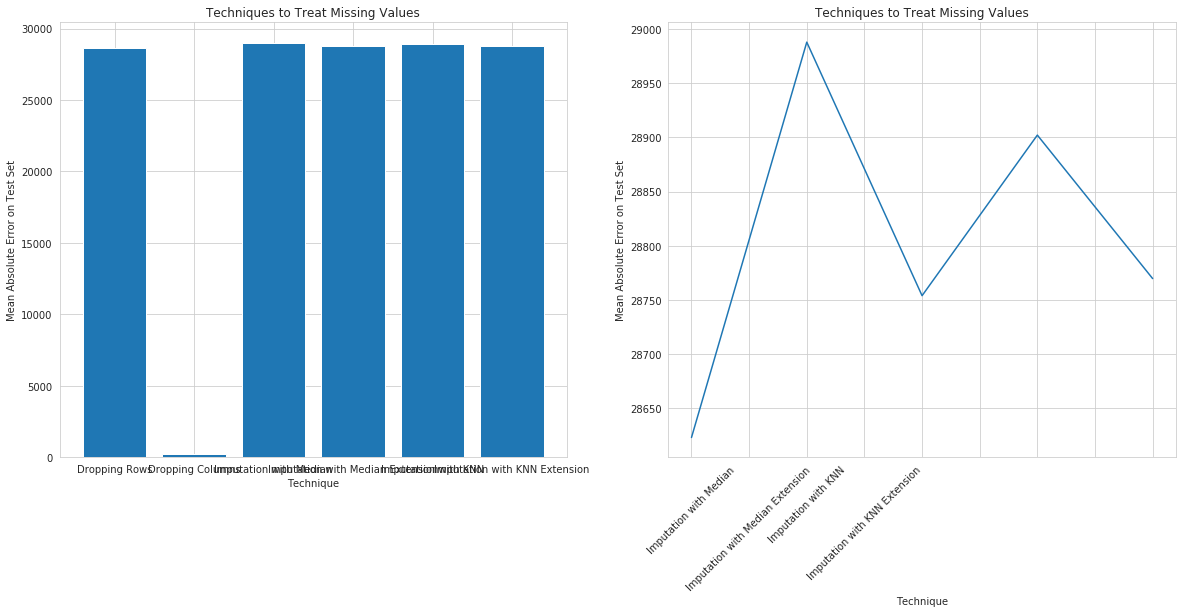

In [112]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(range(len(all_techniques)), all_techniques, tick_label=labels_all_techniques)
ax1.set_title("Techniques to Treat Missing Values")
ax1.set_xlabel("Technique")
ax1.set_ylabel("Mean Absolute Error on Test Set")

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(worse_techniques)
# plt.xticks(range(len(worse_techniques)), labels_worse_techniques)
ax2.set_xticklabels(labels_worse_techniques, rotation=45)
ax2.set_title("Techniques to Treat Missing Values")
ax2.set_xlabel("Technique")
ax2.set_ylabel("Mean Absolute Error on Test Set")

plt.show()